# Working with Sagemaker Pipelines 

- [Overview](#overview)
- [Build the pipeline components](#build-the-pipeline-components)
   1. [Import statements and declare parameters and constants](#import-statements-and-declare-parameters-and-constants)
   2. [Collect and prepare data](#collect-and-prepare-data)
   3. [Define Processing Step](#define-processing-step)
   4. [Define HyperParameter Tuning  Step](#define-hyperparameter-tuning-step)
   5. [Define the evaluation script and model evaluation step](#define-the-evaluation-script-and-model-evaluation-step)
   6. [Define a register model step](#define-a-register-model-step)
   7. [Define a condition step to check AUC score](#define-a-condition-step-to-check-auc-score)
- [Build and Trigger the pipeline run](#build-and-trigger-the-pipeline-run)

## Overview

The following diagram illustrates the high-level architecture of the ML workflow with the different steps to train the model.

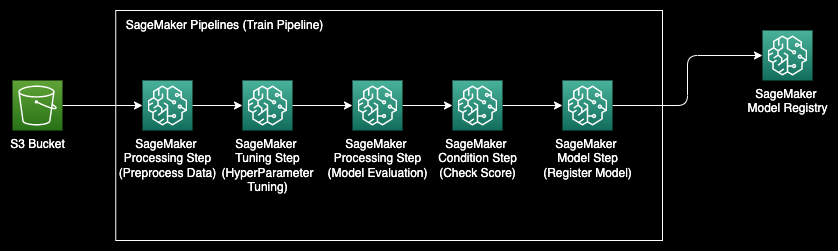

Train Pipeline consists of the following steps:

1. Preprocess data to build features required and split data into train, validation, and test datasets.
2. Apply hyperparameter tuning based on the ranges provided with the SageMaker XGBoost framework to give the best model, which is determined based on AUC score.
3. Evaluate the trained model using the test dataset and check if the AUC score is above a predefined threshold.
4. Check if the AUC score is greater than the threshold, if true register the model into SageMaker model registry.

## Build the pipeline components

# Imports

In [ ]:
import boto3
import pandas as pd
import sagemaker

from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.workflow.steps import TuningStep
from sagemaker.processing import ScriptProcessor

from sagemaker import Model
from sagemaker.workflow.model_step import ModelStep
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.properties import PropertyFile

from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

import json
from sagemaker.workflow.pipeline import Pipeline

### Step 1: Import statements and declare parameters and constants

## Set-up

In [ ]:
%pip install --upgrade boto3

In [ ]:
# AWS S3 Client
s3_client = boto3.resource('s3')

# SageMaker Pipeline Name
pipeline_name = f"sagemaker-mlops-train-pipeline"

# SageMaker Session
sagemaker_session = sagemaker.Session()

# AWS Region
region = sagemaker_session.boto_region_name

# SageMaker Execution Role
role = sagemaker.get_execution_role()

# SageMaker Pipeline Session
pipeline_session = PipelineSession()

# Default S3 Bucket
default_bucket = sagemaker_session.default_bucket()

# SageMaker Model Package Group Name
model_package_group_name = f"ChurnModelPackageGroup"

In [ ]:
# AUC Score Threshold
auc_score_threshold = 0.75

# Base Job Prefix
base_job_prefix = "churn-example"

# Processing Instance Count
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

# Processing Instance Type
processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value="ml.m5.xlarge")

# Training Instance Type
training_instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")

# Input Data
input_data = "storedata_total.csv"

# Model Approval Status
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value="PendingManualApproval")

### Step 2: Collect and prepare data

In [ ]:
!wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/dataset/storedata_total.xlsx

In [ ]:
# Read Data from Excel
store_data = pd.read_excel("storedata_total.xlsx")

# Convert Data to CSV
store_data.to_csv("storedata_total.csv")


### Step 3: Define Processing Step

In [ ]:
!wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/preprocess-churn.py

In [ ]:
!pygmentize "preprocess-churn.py"

In [ ]:
input_data

In [ ]:
# Define Processing Step for Feature Engineering

# Specify the framework version for SKLearnProcessor
framework_version = "1.0-1"

# Create an SKLearnProcessor object for feature engineering
sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=processing_instance_count,
    base_job_name="sklearn-churn-process",
    role=role,
    sagemaker_session=pipeline_session,
)

# Define processor arguments for running the processing job
processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(
            output_name="train",
            source="/opt/ml/processing/train",
            destination=f"s3://{default_bucket}/output/train"
        ),
        ProcessingOutput(
            output_name="validation",
            source="/opt/ml/processing/validation",
            destination=f"s3://{default_bucket}/output/validation"
        ),
        ProcessingOutput(
            output_name="test",
            source="/opt/ml/processing/test",
            destination=f"s3://{default_bucket}/output/test"
        )
    ],
    code=f"preprocess-churn.py",
)

# Create a ProcessingStep for the ChurnModelProcess
step_process = ProcessingStep(
    name="ChurnModelProcess",
    step_args=processor_args
)

### Step 4: Define HyperParameter Tuning  Step

In [ ]:
# Define the S3 path for model output
model_path = f"s3://{default_bucket}/output"

# Retrieve the SageMaker image URI for XGBoost
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)

# Define fixed hyperparameters for XGBoost training
fixed_hyperparameters = {
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "num_round": "100",
    "rate_drop": "0.3",
    "tweedie_variance_power": "1.4"
}

# Create an Estimator for XGBoost training
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    output_path=model_path,
    base_job_name=f"churn-train",
    sagemaker_session=pipeline_session,
    role=role,
)

In [ ]:
# Define hyperparameter ranges for hyperparameter tuning
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

# Specify the objective metric name for hyperparameter tuning
objective_metric_name = "validation:auc"

# Create a HyperparameterTuner for XGBoost
tuner = HyperparameterTuner(
    xgb_train,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=2,
    max_parallel_jobs=2,
)

# Fit the tuner with input data for hyperparameter tuning
hpo_args = tuner.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["validation"].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

# Create a TuningStep for hyperparameter tuning
step_tuning = TuningStep(
    name="ChurnHyperParameterTuning",
    step_args=hpo_args,
)

### Step 5: Define the evaluation script and model evaluation step

In [ ]:
!wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/evaluate-churn.py

In [ ]:
!pygmentize "evaluate-churn.py"

In [ ]:
# Define model evaluation step to evaluate the trained model

# Create a ScriptProcessor for model evaluation
script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="script-churn-eval",
    role=role,
    sagemaker_session=pipeline_session,
)

# Define evaluation arguments and run the evaluation script
eval_args = script_eval.run(
     inputs=[
        ProcessingInput(
            source=step_tuning.get_top_model_s3_uri(top_k=0, s3_bucket=default_bucket, prefix="output"),
            destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="evaluation",
            source="/opt/ml/processing/evaluation",
            destination=f"s3://{default_bucket}/output/evaluation"
        ),
    ],
    code=f"evaluate-churn.py",
)

# Define a PropertyFile for storing the evaluation report
evaluation_report = PropertyFile(
    name="ChurnEvaluationReport",
    output_name="evaluation",
    path="evaluation.json"
)

# Create a ProcessingStep for model evaluation
step_eval = ProcessingStep(
    name="ChurnEvalModel",
    step_args=eval_args,
    property_files=[evaluation_report],
)

### Step 6: Define a register model step

In [ ]:
# Define a SageMaker Model

# Create a SageMaker Model using the specified image URI and model data
model = Model(
    image_uri=image_uri,
    model_data=step_tuning.get_top_model_s3_uri(top_k=0, s3_bucket=default_bucket, prefix="output"),
    sagemaker_session=pipeline_session,
    role=role,
)

# Define model metrics for model evaluation
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

# Register the model with SageMaker Model Registry
register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)

# Create a ModelStep for registering the model
step_register = ModelStep(name="ChurnRegisterModel", step_args=register_args)

### Step 7: Define a condition step to check AUC score

In [ ]:
# Define a Condition Step to Check AUC Score

# Define a condition that checks if the AUC score is greater than or equal to a threshold
cond_lte = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="classification_metrics.auc_score.value",
    ),
    right=auc_score_threshold,
)

# Create a ConditionStep to check the AUC score and register the model if the condition is met
step_cond = ConditionStep(
    name="CheckAUCScoreChurnEvaluation",
    conditions=[cond_lte],
    if_steps=[step_register],
)

## Build and Trigger the pipeline run

After defining all of the component steps, you can assemble them into a Pipelines object. You don’t need to specify the order of pipeline because Pipelines automatically infers the order sequence based on the dependencies between the steps.

In [ ]:
# Define a SageMaker Pipeline

# Create a SageMaker Pipeline with specified parameters and steps
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        processing_instance_type,
        training_instance_type,
        model_approval_status,
        input_data,
        auc_score_threshold,
    ],
    steps=[step_process, step_tuning, step_eval, step_cond],
)

# Convert the pipeline definition to JSON format
definition = json.loads(pipeline.definition())

# Print the pipeline definition for reference
print(definition)

In [ ]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=role)
# start Pipeline execution
pipeline.start()